In [2]:
import pandas as pd
import numpy as np
import joblib
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBClassifier
import contextlib
import re
import io
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats

# Set global random seed for reproducibility
np.random.seed(42)
random.seed(42)

warnings.filterwarnings('ignore')  # To suppress warnings for clarity
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [3]:
def compute_auc_ci(y_true: np.ndarray, y_scores: np.ndarray, alpha: float = 0.95) -> tuple:
    """
    Compute the confidence interval for the AUC score using the Hanley-McNeil method.

    Parameters:
        y_true (np.ndarray): True binary labels.
        y_scores (np.ndarray): Target scores (probabilities or confidence values).
        alpha (float): Confidence level for the interval.

    Returns:
        tuple: Lower and upper bounds of the confidence interval.
    """

    auc_score = roc_auc_score(y_true, y_scores)
    n1 = sum(y_true)
    n2 = len(y_true) - n1
    q1 = auc_score / (2 - auc_score)
    q2 = 2 * auc_score**2 / (1 + auc_score)
    se_auc = np.sqrt((auc_score * (1 - auc_score) +
                      (n1 - 1) * (q1 - auc_score**2) +
                      (n2 - 1) * (q2 - auc_score**2)) / (n1 * n2))
    lower = auc_score - stats.norm.ppf(1 - (1 - alpha) / 2) * se_auc
    upper = auc_score + stats.norm.ppf(1 - (1 - alpha) / 2) * se_auc
    return max(0, lower), min(1, upper)

def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

def load_and_preprocess_data(file_path: str, save_scalers: bool = False) -> tuple:
    """
    Load data from an Excel file, handle missing values, encode categorical variables,
    and scale numerical features.

    Parameters:
        file_path (str): Path to the Excel file.
        save_scalers (bool): If True, saves the scaler to disk using joblib.

    Returns:
        tuple: A tuple containing the features DataFrame (X) and target Series (y).
    """
    # Attempt to load the Excel file
    try:
        # Skip the first row for proper column names
        data = pd.read_excel(file_path, skiprows=1)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None, None
    except ValueError as e:
        print(f"Error loading Excel file: {e}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None

    # Rename columns for easier access
    data.columns = [
        "No", "Sex M/F", "BCG - therapy [YES/NO]", "Serum PAI-1", "Serum sUPAR",
        "Serum IL-8", "Urine IL-8", "Urine VEGF", "Urine APOE",
        "EORTC progression points", "EORTC progression class", "Outcome 0/1"
    ]

    # Drop irrelevant columns
    data.drop(["No", "EORTC progression class"], axis=1, inplace=True)

    # Fill missing numerical values with the mean
    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        data[col].fillna(data[col].mean(), inplace=True)

    # Fill missing categorical values with the mode
    for col in data.select_dtypes(include=['object']).columns:
        data[col].fillna(data[col].mode()[0], inplace=True)

    # Encode categorical data properly
    label_encoder = LabelEncoder()
    for col in ["Sex M/F", "BCG - therapy [YES/NO]"]:
        data[col] = label_encoder.fit_transform(data[col])

    # Convert outcome to binary numeric
    data["Outcome 0/1"] = data["Outcome 0/1"].apply(lambda x: 1 if x == 1 else 0)

    # Separate features and target
    X = clean_column_names(data.drop("Outcome 0/1", axis=1))
    y = data["Outcome 0/1"]

    # Scale numeric columns
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # Save the scaler if required
    if save_scalers:
        joblib.dump(scaler, 'scaler.pkl')

    return X, y

# Load and preprocess the data
INPUT_DATA_FILEPATH = "./InputData.xlsx"
X, y = load_and_preprocess_data(INPUT_DATA_FILEPATH)

# Check if data was loaded successfully
if X is None or y is None:
    raise Exception("Data loading failed. Please check the file path and data format.")

# Handle class imbalance using SMOTE with fixed random_state
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets with fixed random_state
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

### Training

In [4]:
# Define models and their parameter grids for RandomizedSearchCV

MODELS = {
    "Random Forest": (RandomForestClassifier(),
        {
            'n_estimators': [100, 200, 500],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True, False],
            'class_weight': ['balanced', None],
            'random_state': [42]
        }),
    "SVC": (SVC(probability=True),
        {
            'C': [0.1, 0.5, 1, 1.2, 1.5],
            'kernel': ['linear'],
            'gamma': ['scale', 'auto'],
            'class_weight': ['balanced', None]
            # SVC does not accept random_state when probability=True
        }),
    "Naive Bayes": (GaussianNB(),
        {
            'var_smoothing': np.logspace(0, -9, num=100)
            # GaussianNB does not have a random_state parameter
        }),
    "KNN": (KNeighborsClassifier(),
        {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
            # KNeighborsClassifier does not have a random_state parameter
        }),
    "MLP": (MLPClassifier(max_iter=1000),
        {
            'hidden_layer_sizes': [(5,), (10,), (20,), (5, 5), (10, 10)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'random_state': [42]
        }),
    "AdaBoost": (AdaBoostClassifier(),
        {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1],
            'algorithm': ['SAMME', 'SAMME.R'],
            'random_state': [42]
        }),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.7, 1],
            'colsample_bytree': [0.7, 1],
            'random_state': [42]
        }),
    "LightGBM": (LGBMClassifier(),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'boosting_type': ['gbdt', 'dart'],
            'num_leaves': [15, 31, 63],               # Reduced to ensure leaves are manageable
            'max_depth': [3, 5, 7, -1],               # Depth of trees
            'min_child_samples': [10, 20, 30],        # Minimum samples for a node split
            'min_split_gain': [0, 0.1, 0.2],          # Minimum gain for a split to occur
            'feature_fraction': [0.8, 0.9, 1.0],      # Fraction of features to consider for each iteration
            'bagging_fraction': [0.8, 0.9, 1.0],      # Fraction of data to use for each iteration
            'bagging_freq': [1, 5],                   # Frequency of bagging
            'lambda_l1': [0, 0.1, 0.5],               # L1 regularization
            'lambda_l2': [0, 0.1, 0.5]                # L2 regularization
        })
}

# Dictionary to store ROC AUC results and trained models
roc_results = {}
trained_models = {}

# Use StratifiedKFold for cross-validation with fixed random_state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Running RandomizedSearchCV for each model
for name, (model, param_grid) in MODELS.items():
    print(f"Training {name}...")
    # Set random_state directly if the model has the attribute
    if hasattr(model, 'random_state'):
        model.random_state = 42
    
    training_logs = io.StringIO()
    with contextlib.redirect_stdout(training_logs):
        randomized_search = RandomizedSearchCV(
            model,
            param_distributions=param_grid,
            n_iter=50,
            cv=cv,
            scoring='roc_auc',
            n_jobs=1,  # Set to 1 for reproducibility
            random_state=42
        )
        randomized_search.fit(X_train, y_train)
        best_model = randomized_search.best_estimator_
        trained_models[name] = best_model
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        auc_lower, auc_upper = compute_auc_ci(y_test, y_pred_proba)
        roc_results[name] = (fpr, tpr, roc_auc, auc_lower, auc_upper)


Training Random Forest...
Training SVC...
Training Naive Bayes...
Training KNN...
Training MLP...
Training AdaBoost...
Training XGBoost...
Training LightGBM...


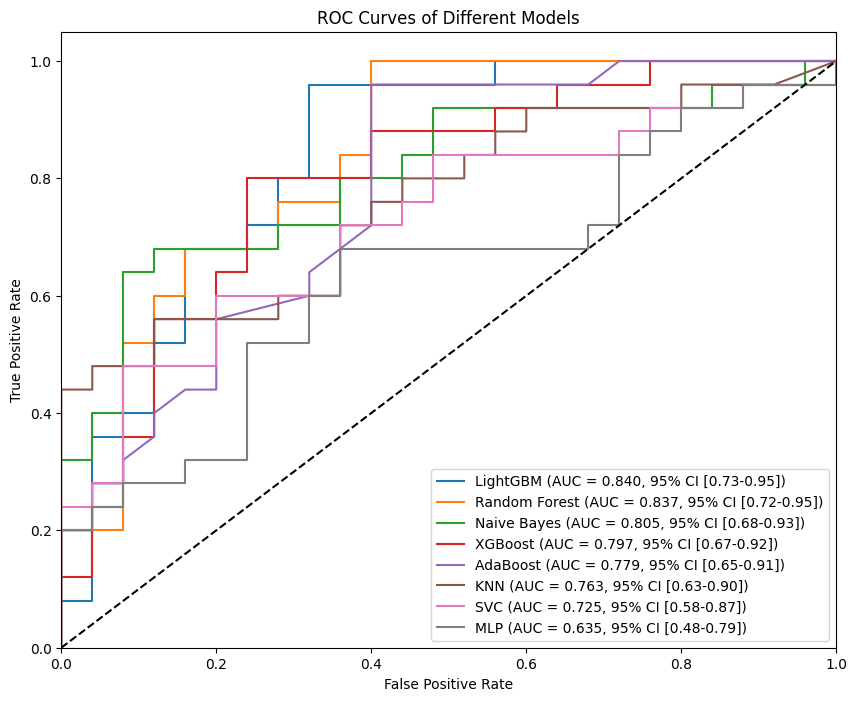

Random Forest: AUC = 0.8368 with 95% CI [0.7235-0.9501]
SVC: AUC = 0.7248 with 95% CI [0.5836-0.8660]
Naive Bayes: AUC = 0.8048 with 95% CI [0.6820-0.9276]
KNN: AUC = 0.7632 with 95% CI [0.6300-0.8964]
MLP: AUC = 0.6352 with 95% CI [0.4808-0.7896]
AdaBoost: AUC = 0.7792 with 95% CI [0.6497-0.9087]
XGBoost: AUC = 0.7968 with 95% CI [0.6718-0.9218]
LightGBM: AUC = 0.8400 with 95% CI [0.7277-0.9523]


In [ ]:
# Plotting ROC Curves and printing AUC with Confidence Interval
plt.figure(figsize=(10, 8))
sorted_roc_results = dict(sorted(roc_results.items(), key=lambda item: item[1][2], reverse=True))
for name, (fpr, tpr, roc_auc, auc_lower, auc_upper) in sorted_roc_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f}, 95% CI [{auc_lower:.2f}-{auc_upper:.2f}])")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Different Models')
plt.legend(loc="lower right")
plt.show()

# Print out the AUC and confidence intervals
for name, (_, _, roc_auc, auc_lower, auc_upper) in roc_results.items():
    print(f"{name}: AUC = {roc_auc:.4f} with 95% CI [{auc_lower:.4f}-{auc_upper:.4f}]")

### Feature Importance

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Dictionary to store feature importances from each model
feature_importance_data = {}

# Extract feature importances from each model that has them
for name, model in trained_models.items():
    if hasattr(model, 'feature_importances_'):
        print(f"\nFeature importances for {name}:")
        importances = model.feature_importances_
        feature_names = X.columns
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_data[name] = feature_importance_df.set_index('Feature')['Importance']
        
        # Print sorted feature importances
        print(feature_importance_df.sort_values('Importance', ascending=False))

# Combine the feature importance data into a DataFrame
feature_importance_df = pd.DataFrame(feature_importance_data)

# Normalize each model's feature importance values to [0, 1] for consistent scaling
scaler = MinMaxScaler()
feature_importance_df_normalized = pd.DataFrame(scaler.fit_transform(feature_importance_df), 
                                                index=feature_importance_df.index, 
                                                columns=feature_importance_df.columns)


Feature importances for Random Forest:
                    Feature  Importance
6                Urine_VEGF    0.223216
8  EORTC_progression_points    0.166823
3               Serum_sUPAR    0.156224
7                Urine_APOE    0.110496
5                Urine_IL_8    0.109491
4                Serum_IL_8    0.101402
2               Serum_PAI_1    0.093022
0                   Sex_M_F    0.025054
1       BCG_therapy_YES_NO_    0.014271

Feature importances for AdaBoost:
                    Feature  Importance
6                Urine_VEGF    0.362517
8  EORTC_progression_points    0.254085
4                Serum_IL_8    0.252210
3               Serum_sUPAR    0.090566
5                Urine_IL_8    0.040623
0                   Sex_M_F    0.000000
2               Serum_PAI_1    0.000000
1       BCG_therapy_YES_NO_    0.000000
7                Urine_APOE    0.000000

Feature importances for XGBoost:
                    Feature  Importance
8  EORTC_progression_points    0.193468
6          

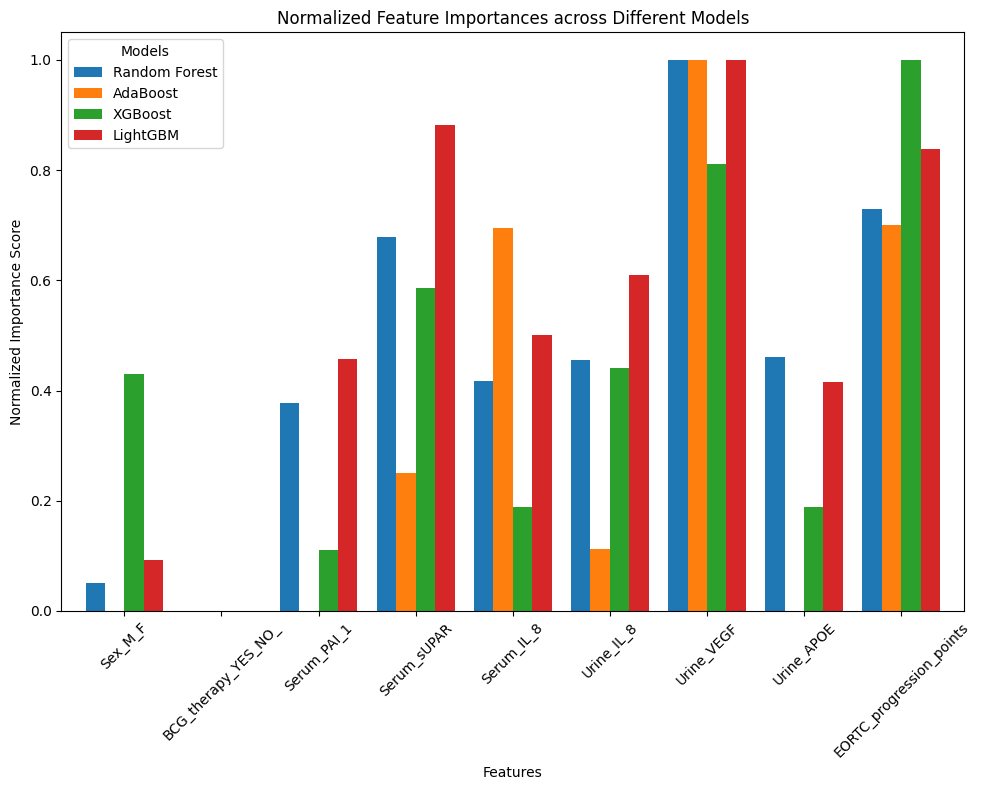

In [13]:
# Plotting the grouped bar chart with normalized values
feature_importance_df_normalized.plot(kind='bar', figsize=(10, 8), width=0.8)
plt.title("Normalized Feature Importances across Different Models")
plt.xlabel("Features")
plt.ylabel("Normalized Importance Score")
plt.xticks(rotation=45)
plt.legend(title="Models")
plt.tight_layout()
plt.show()